In [20]:
import sympy
from sympy import Basic, Equality
from sympy import S, solve, Matrix, diff, plot, simplify, factor, symbols
from sympy import log as Log
from sympy import sin as Sin
from sympy import cos as Cos
from sympy.plotting import plot3d, plot3d_parametric_line
from sympy.plotting.plot import Plot
from sympy.geometry import Point
%matplotlib inline
%matplotlib widget

In [21]:
from typing import overload, Callable, Optional, Tuple, Any

from sympy import latex
from sympy.core._print_helpers import Printable
from IPython.display import Latex

# Should be set to 'False' if Google Colab is used.
VS_CODE: bool = True

@overload
def display_with_text(text: Optional[str] = None, *, sep: str = r"\\") -> None:
    ...

@overload
def display_with_text(text: Optional[str] = None, expression: Optional[Any] = None, *, sep: str = r"\\") -> None:
    ...

@overload
def display_with_text(text: Optional[str] = None, *expressions: Any, sep: str = r"\\") -> None:
    ...

def display_with_text(*args, **kwargs) -> None:
    text: Optional[str] = kwargs.get("text", None)
    expression: Optional[Any] = kwargs.get("expression", None)
    
    sep: str = kwargs.get("sep", r"\\")
    if not isinstance(sep, str):
        raise ValueError(f"Keyword argument 'sep' must be type of <class 'str'> (class str)")

    if text is None and args and args[0] is not None:
        text = str(args[0])
    
    if text is not None and not isinstance(text, str):
        text = str(text)
    
    expressions: Tuple[Any] = args[1:]
    if expression is not None:
        expressions += (expression,)

    if not expressions:
        if text is not None:
            text = "$ \\text{" + text + "} $" if VS_CODE else "\\text{" + text + '}'
            display(Latex(text))
        return
    
    expr_processor: Callable[[Any], str] = \
        lambda expr: str(latex(expr) if isinstance(expr, Printable) else expr)
    final_expression: str = sep.join(map(expr_processor, expressions))
    
    if VS_CODE:
        final_expression = "$ " + final_expression + " $"

    if text is not None:
        final_expression = \
            ("$ \\text{" + text + "} $ " if VS_CODE else "\\text{" + text + "} ") \
            + final_expression

    display(Latex(final_expression))


## Занятие 16
## Математический анализ
## Градиент функции нескольких переменных, производная по направлению, касательная плоскость.

    
### Задание 1
Найти градиент функции $z=x^2-xy-2y^2$ в произвольной точке и в точке М(1,2). Вычислить производную  в направлении, составляющем с положительным направлением оси ОХ угол 60 градусов, в точке М(1,2). 

In [22]:
from sympy.abc import x, y

def grad_f(f: Callable[[Basic, Basic], Basic], *symbs: Basic) -> Matrix:
    return Matrix([f(*symbs).diff(symb) for symb in symbs])

def grad_f_point(f: Callable[[Basic, Basic], Basic], p: Point) -> Matrix:
    symbs: dict[Basic, Basic] = {x: p.args[0], y: p.args[1]}
    return grad_f(f, *symbs.keys()).subs(symbs)

z = lambda x, y: x**2 - x*y - 2*y**2
M = Point(1, 2)

display_with_text("Градиент в произвольной точке:", grad_f(z, x, y))
grad_M = grad_f_point(z, M)
display_with_text("Градиент в точке M:", M, grad_M)
vec = Matrix((S(0.5), sympy.sqrt(3)/2))
display_with_text("Производная в точке M в направлении вектора:", vec, grad_M.dot(vec))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

###  Задание 2.
Поверхность задана уравнением $z = \frac{x^2}{2} - y^2$. Составить уравнение касательной плоскости и нормали в точке $М(2, -1, 1)$. Изобразить на графике.

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

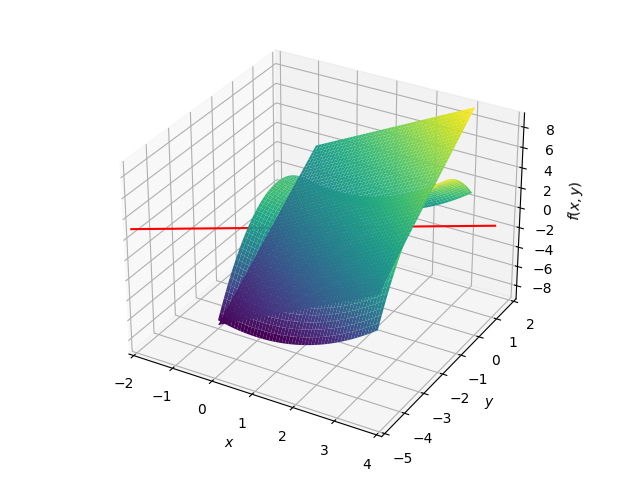

In [23]:
from sympy.abc import x, y, z

def tplane_nline_eq(f: Basic, p: Point) -> Tuple[Equality, Equality]:
    x0, y0, z0 = p.x, p.y, p.z
    subs_dict = {x: x0, y: y0, z: z0}
    df_dx, df_dy = (f.diff(s).subs(subs_dict) for s in (x, y))

    plane_eq = sympy.Eq(z - z0, df_dx*(x - x0) + df_dy*(y - y0))
    norm_line = sympy.Eq(
        sympy.Eq((x - x0)/df_dx, (y - y0)/df_dy, evaluate=False), 
        (z - z0)/(-1),
        evaluate=False
    )
    return (plane_eq, norm_line)

def plot_line(nline_eq: Equality, *symbs: Basic, t_range: Tuple = (-2, 1), **kwargs) -> Plot:
    nline_parametric_args: Tuple[Basic, ...] = (*nline_eq.args[0].args, nline_eq.args[1])
    t = symbols("t", real=True)
    functions = tuple(solve(nline_parametric_args[i] - t, symb)[0] for i, symb in enumerate(symbs))
    return plot3d_parametric_line(*functions, (t, *t_range), show=False, **kwargs)

f = x*x/2 - y*y
M = Point(2, -1, 1)
plane_eq, nline_eq = tplane_nline_eq(f, M)
display_with_text("Уравнение касательной плоскости:", plane_eq)
display_with_text("Уравнение нормали:", nline_eq)

z_x_y = solve(plane_eq, z)[0]
p = plot3d(z_x_y, f, (x, -1, 3), (y, -3, 2), show=False)
p.extend(plot_line(nline_eq, x, y, z, line_color='r'))
p.show()

###  Задание 3.
Поверхность задана уравнением $3xyz - z^3 = a^3$. Составить уравнение касательной плоскости и нормали к поверхности в точке $x = 0$, $y = a$. 

In [24]:
from sympy.abc import x, y, z

def t_plane_nline_eq(F: Basic, p: Point) -> Tuple[Equality, Equality]:
    x0, y0, z0 = p.x, p.y, p.z
    subs_dict = {x: x0, y: y0, z: z0}
    dF_dx, dF_dy, dF_dz = (F.diff(s).subs(subs_dict) for s in (x, y, z))

    plane_eq = sympy.Eq(simplify(dF_dx*(x - x0) + dF_dy*(y - y0) + dF_dz*(z - z0)), 0, evaluate=False)
    norm_line_eq = sympy.Eq(
        sympy.Eq(simplify((x - x0)/dF_dx), simplify((y - y0)/dF_dy), evaluate=False), 
        simplify((z - z0)/dF_dz),
        evaluate=False
    )
    return (plane_eq, norm_line_eq)


Рекомендуется разложить на множители левую часть уравнения касательной плоскости и затем записать ее в более простом виде, считая $a \neq 0$:

In [25]:
a = sympy.Symbol('a', real=True)
F = 3*x*y*z - z**3 - a**3
M = Point(0, a, -a)
plane_eq, nline_eq = t_plane_nline_eq(F, M)
display_with_text("Уравнение нормали:", nline_eq)
display_with_text("Уравнение касательной плоскости:", plane_eq)
plane_eq_simplified = sympy.factor(plane_eq.args[0], (x, y, z))
display_with_text("Упрощённое касательной уравнение плоскости:", sympy.Eq(plane_eq_simplified, 0))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

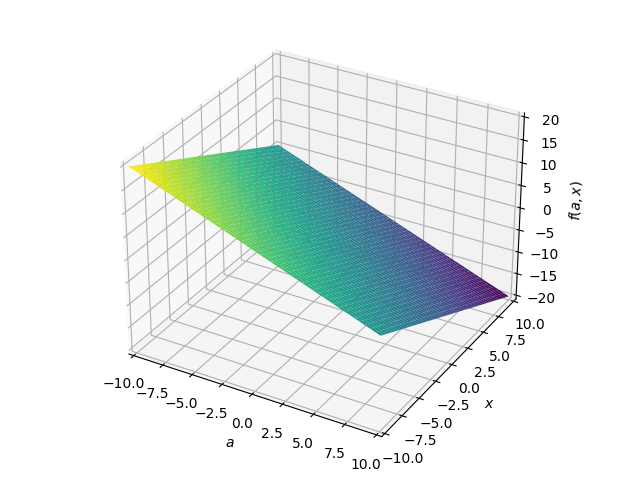

In [26]:
z_x_y = solve(plane_eq_simplified, z)[0]
plot3d(z_x_y, (x, -1, 3))

### Индивидуальное задание.
Поверхность задана уравнением $f$. Составить уравнение касательной плоскости и нормали в точке $(R\cos\alpha,R\sin\alpha,R)$.  Изобразить на графике при $R=$ значение из ИДЗ, $\alpha=$значение из ИДЗ.

$ x^2−18x + y^2+ z^2 = 0 $ \
$ R = 9 $ \
$ α = 1.74π $

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

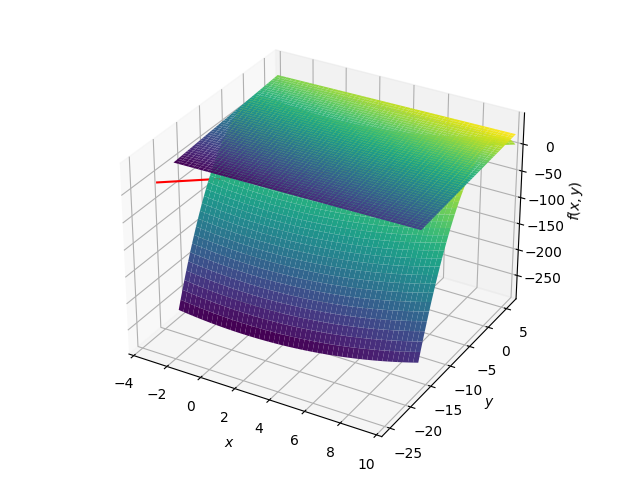

In [27]:
from sympy.abc import x, y, z

R = 9
alpha = S(174) / 100 * sympy.pi
F = x**2 - 18*x + y**2 + z**2
M = Point(R*Cos(alpha), R*Sin(alpha), R)
plane_eq, nline_eq = t_plane_nline_eq(F, M)
display_with_text("Уравнение касательной плоскости в точке:", plane_eq)
display_with_text("Уравнение нормали в точке:", nline_eq)

z_x_y = solve(plane_eq, z)[0]
p = plot3d(z_x_y, f, (x, -4, 10), (y, -17, 7), show=False)
p.extend(plot_line(nline_eq, x, y, z, t_range=(-0.5, 1.5), line_color='r'))
p.show()